## MIE424 (2023 Winter) Lab 2

In this lab, you will be implementing the Bisection method for finding a local optimum of a univariate function. See Chapter 3.7 in [ALG].

In [2]:
from typing import Callable, Tuple, Optional

import matplotlib.pyplot as plt
import abc
import math
import numpy as np

%matplotlib inline

### The UnivariateFunction class

In this lab, we define each test function to be a child class of the superclass called *UnivariateFunction*. Any class that inherits this superclass should be specified by a domain and range (range is only for visualization). Also, we need to implement the *prime* method which returns the derivative of the function evaluated at a specific $x$ value.

In [3]:
class UnivariateFunction:
    def __init__(self, a: float, b: float, ya: Optional[float] = None, yb: Optional[float] = None):
        self.a: float = a
        self.b: float = b
        if ya is not None:
            self.ya: float = ya
        if yb is not None:
            self.yb: float = yb
    
    @abc.abstractmethod
    def prime(self, *args, **kwargs) -> float:
        """Implement f'(x)=df/dx(x)"""
        pass

    @abc.abstractmethod
    def __call__(self, x: float) -> float:
        """Implement f(x)"""
        pass
    
    @property
    def xrange(self):                       # Just for plotting
        if not hasattr(self, '_xrange'):
            self._xrange = np.linspace(self.a, self.b, 100)
        return self._xrange

    def plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$f$')
        ax.set_xlim(self.a, self.b)
        ax2 = ax.twinx()
        ax2.set_ylabel(r"$f'$")
        if hasattr(self, 'ya') and hasattr(self, 'yb'):
            ax.set_ylim(self.ya, self.yb)
        fline = ax.plot(self.xrange, np.vectorize(self)(self.xrange), 'b-', label='f')
        f_p_line = ax2.plot(self.xrange, np.vectorize(self.prime)(self.xrange), 'c-', label="f'")
        f_p_zero = ax2.axhline(0, color='c', linestyle='-.', lw=1)
        lines = fline + f_p_line
        ax.legend(lines, [l.get_label() for l in lines], loc=0)
        return fig, ax

Let's now define an example test function to play with (Problem02 from [here](http://infinity77.net/global_optimization/test_functions_1d.html)):
 $f_{P2}(x) = \sin(x) + \sin\big(\frac{10}{3}x\big)$.

The domain bound constraint is $x\in[2.7,7.5]$; and a rough range is $y\in [-2.0, 1.0]$.

With this, complete the following code that implements $f(x)$ and $f'(x)$.

In [4]:
class Problem2(UnivariateFunction):

    def __init__(self, a: float = 2.7, b: float = 7.5, ya=-2.0, yb=1.0):
        super().__init__(a, b, ya=ya, yb=yb)
    
    def prime(self, x: float) -> float:
        ####################################
        # Your code here
        
        return math.cos(x) + 10/3*math.cos(10/3*x)
        return
        ####################################
        
    
    def __call__(self, x: float) -> float:
        ####################################
        # Your code here
        return math.sin(x) + math.sin(10/3*x)
        return
        ####################################

(<Figure size 300x300 with 2 Axes>, <AxesSubplot: xlabel='$x$', ylabel='$f$'>)

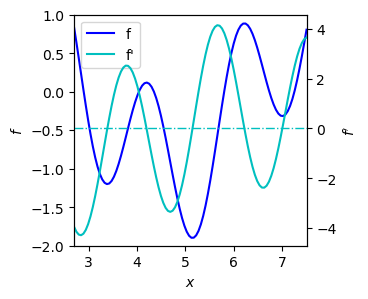

In [5]:
f2 = Problem2()
f2.plot()

### The Optimizer class

Now, let's define an abstract Optimizer class. An Optimizer object should specify which objective function it is optimizing. Then, by calling the *optimize* method, it should run optimization.

In [4]:
class Optimizer:
    def __init__(self, func: UnivariateFunction) -> None:
        self.obj_func = func

    @abc.abstractmethod
    def optimize(self, *args, **kwargs):
        """An abstract method that every Opimizer class should implement"""
        pass
    
    @property
    def obj_func(self) -> UnivariateFunction:
        return self._obj_func
    
    @obj_func.setter
    def obj_func(self, obj_func: UnivariateFunction):
        self._obj_func: UnivariateFunction = obj_func
    
    def plot(self, a: float, b: float, i: int):
        fig, ax = self.obj_func.plot()
        aline = ax.axvline(a, color='g', linestyle='--')
        bline = ax.axvline(b, color='m', linestyle='--')
        ax.set_title(f"Iteration: {i}")
        fig.canvas.draw()

### The Bisection method 
The Bisection method finds an interval within which a local optimum of a given univariate function exists. The local optimum can be a local minimum or maximum; hence, the method itself is not necessarily an algorithm we can use to specifically find either a local minimum or maximum.  In any event, let's just call this an optimizer and name the class as *BisectionOptimizer* that inherits the *Optimizer* class.

We have given you the code for the *optimize* method which calls two subroutines: (1) *bisection* and (2) *get_initial_interval*. Specifically, we get an initial interval to begin the bisection method with from the *get_initial_interval* method which is presented in Algorithm 3.7 of the ALG textbook. Starting from this interval, the *bisection* method should implement Algorithm 3.6 of the ALG textbook, which returns the final interval that contains a local optimum.

**Problem 2.1** Implement the bisection algorithm given in Algorithm 3.6 of the ALG textbook.

**Problem 2.2** Implement Algorithm 3.7 of the ALG textbook.

In [5]:
class BisectionOptimizer(Optimizer):
    def __init__(self, func: UnivariateFunction) -> None:
        super().__init__(func)
        self.iter, self.tol = 0, 1e-4

    def optimize(
            self, *args, tol: float=1e-4, plot_period: Optional[int] = None, **kwargs
    ) -> Tuple[float, float]:
        """Optimizes the associated univariate function `obj_func` up to 
            a specified tolerance using the Bisection method

        Args:
            tol (float, optional): _description_. Defaults to 1e-4.
        """
        init_a = self.obj_func.a + (self.obj_func.b - self.obj_func.a) / 4
        init_a, init_b = self.get_initial_interval(self.obj_func.prime, init_a, init_a+tol, k=kwargs.get('k', 2))
        a, b = self.bisection(self.obj_func.prime, init_a, init_b, tol=tol, plot_period=plot_period)
        return a, b
    
    def bisection(
            self, func: Callable, a: float, b: float, tol: float, plot_period: Optional[int] = None,
    ) -> Tuple[float, float]:
        """Given a callable univariate function `func` and an interval [a, b], 
            find a new interval that contains a root of the function.

        Args:
            func (Callable): The univariate function
            a (float): The start of the initial interval
            b (float): The end of the initial interval
            tol (float)
            plot_period(int, optional): How often plot the function and current interval.
        """
        if a > b:
            a, b = b, a                 # Ensure a < b
        
        ya, yb = func(a), func(b)
        if ya == 0:
            b = a
        if yb == 0:
            a = b
        
        if plot_period:
            self.plot(a, b, 0)

        i = 1
        while b - a > tol:
            ####################################
            # Your code here

            x = (a + b) / 2             # The midpoint
            y = func(x)                 # Function value at the midpoint
            if y == 0:
                a, b = x, x
            elif (y > 0 and ya > 0) or (y < 0 and ya < 0):
                a = x
            else:
                b = x

            ####################################
            
            if plot_period and i % plot_period == 0:
                self.plot(a, b, i)
            i += 1
            
        self.iter, self.tol = i - 1, tol
        return (a, b)

    def get_initial_interval(
            self, func: Callable, a: float, b: float, k: float = 2.0,
    ) -> Tuple[float, float]:
        """Given a callable univariate function `func` and the initial interval [a, b], 
            find a new interval such that `func(a)` and `func(b)` have different signs.

        Args:
            func (Callable): The univariate function
            a (float): The start of the initial interval
            b (float): The end of the initial interval
            k (float, optional): The expansion factor. Defaults to 2.

        Returns:
            Tuple[float, float]: A new interval [a_, b_] such that func(a_) and func(b_) have
                different signs.
        """
        if a > b:
            a, b = b, a                 # Ensure a < b
        
        ####################################
        # Your code here
        
        center, half_width = (a + b)/2, (b - a)/2
        while func(a) * func(b) > 0:
            half_width *= k
            a = center - half_width
            b = center + half_width
        ####################################

        return a, b
    

### Test your implementation

Now, let's test your implementation to see if everything works as intended.

In [6]:
f2 = Problem2()                     # Instantiate the test function 
optimizer = BisectionOptimizer(f2)  # Instantiate the bisection optimizer

In [7]:
a, b = optimizer.optimize()
print(f"Obtained interval: [{a}, {b}]")
print(f"Function values: [{f2(a)}, {f2(b)}]")
print(f"f' values: [{f2.prime(a)}, {f2.prime(b)}]")
print(f"Number of iterations: {optimizer.iter} (tol={optimizer.tol})")

Obtained interval: [4.1965500000006255, 4.196600000000625]
Function values: [0.11909022018069237, 0.11909023094221993]
f' values: [0.0004681993741384449, -3.77403542414223e-05]
Number of iterations: 14 (tol=0.0001)


You can pass in a keyword argument *plot_period* into the *optimize* method to visualize the progress of the Bisection method. 

Obtained interval: [4.1965500000006255, 4.196600000000625]


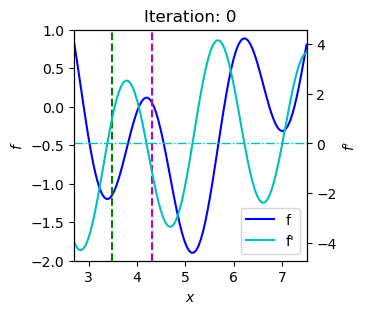

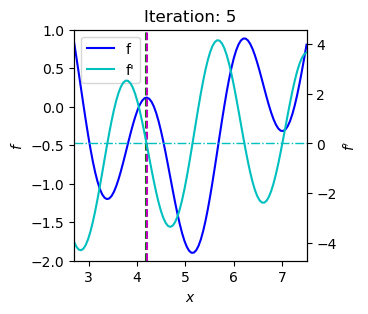

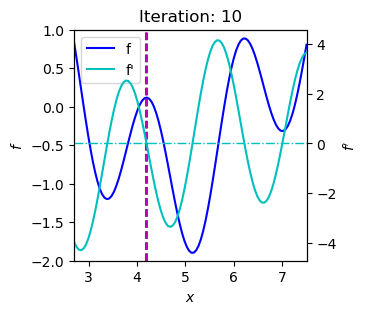

In [8]:
a, b = optimizer.optimize(plot_period=5)
print(f"Obtained interval: [{a}, {b}]")

### Test on different test functions

2. Problem04

$f_{P4}(x) = -(16x^2-24x+5)\cdot e^{-x}$

The domain bound constraint is $x\in[1.9, 3.9]$; and a rough range is $y\in [-4.0, -2.4]$.

In [9]:
class Problem4(UnivariateFunction):

    def __init__(self, a: float = 1.9, b: float = 3.9, ya=-4.0, yb=-2.4):
        super().__init__(a, b, ya=ya, yb=yb)
    
    def prime(self, x: float) -> float:
        ####################################
        # Your code here

        return (16*math.pow(x, 2) - 56*x + 29) * math.exp(-x)

        ####################################
    
    def __call__(self, x: float) -> float:
        ####################################
        # Your code here

        return -(16*math.pow(x, 2) - 24*x + 5) * math.exp(-x)
        
        ####################################

In [10]:
f4 = Problem4()
optimizer.obj_func = f4         # Change the objective function
a, b = optimizer.optimize()
print(f"Obtained interval: [{a}, {b}]")
print(f"Function values: [{f4(a)}, {f4(b)}]")
print(f"f' values: [{f4.prime(a)}, {f4.prime(b)}]")
print(f"Number of iterations: {optimizer.iter} (tol={optimizer.tol})")

Obtained interval: [2.868000000000988, 2.868050000000988]
Function values: [-3.8504507076261887, -3.850450708539693]
f' values: [-6.908392248550422e-05, 3.254281175716124e-05]
Number of iterations: 15 (tol=0.0001)


3. Problem05

$f_{P5}(x) = -(1.4 - 3x)\cdot \sin(18x)$

The domain bound constraint is $x\in[0, 1.2]$; and a rough range is $y\in [-1.5, 2.5]$.

In [11]:
class Problem5(UnivariateFunction):

    def __init__(self, a: float = 0., b: float = 1.2, ya=-1.5, yb=2.5):
        super().__init__(a, b, ya=ya, yb=yb)
    
    def prime(self, x: float) -> float:
        ####################################
        # Your code here

        return 3*(18*x - 8.4) * math.cos(18*x) + 3*math.sin(18*x)
        ####################################
    
    def __call__(self, x: float) -> float:
        ####################################
        # Your code here

        return -(1.4 - 3*x) * math.sin(18*x)

        ####################################

In [12]:
f5 = Problem5()
optimizer.obj_func = f5
a, b = optimizer.optimize()
print(f"Obtained interval: [{a}, {b}]")
print(f"Function values: [{f5(a)}, {f5(b)}]")
print(f"f' values: [{f5.prime(a)}, {f5.prime(b)}]")
print(f"Number of iterations: {optimizer.iter} (tol={optimizer.tol})")

Obtained interval: [0.24795000000000567, 0.24805000000000565]
Function values: [0.6358671475288157, 0.6358666457488242]
f' values: [0.00661236899965445, -0.016644825553592923]
Number of iterations: 12 (tol=0.0001)


4. Problem07

$f_{P7}(x) = \sin(x) + \sin\big(\frac{10}{3} x \big)+\log(x) -0.84x + 3$

The domain bound constraint is $x\in[2.7,7.5]$; and a rough range is $y\in [-2.0, 3.0]$.

In [13]:
class Problem7(UnivariateFunction):

    def __init__(self, a: float = 2.7, b: float = 7.5, ya=-2.0, yb=3.0):
        super().__init__(a, b, ya=ya, yb=yb)
    
    def prime(self, x: float) -> float:
        ####################################
        # Your code here

        return math.cos(x) + 10/3*math.cos(10/3*x) + 1/x - 0.84
        ####################################
        
    def __call__(self, x: float) -> float:
        ####################################
        # Your code here

        return math.sin(x) + math.sin(10/3*x) + math.log(x) - 0.84*x + 3

        ####################################

In [14]:
f7 = Problem7()
optimizer.obj_func = f7
a, b = optimizer.optimize()
print(f"Obtained interval: [{a}, {b}]")
print(f"Function values: [{f7(a)}, {f7(b)}]")
print(f"f' values: [{f7.prime(a)}, {f7.prime(b)}]")
print(f"Number of iterations: {optimizer.iter} (tol={optimizer.tol})")

Obtained interval: [4.136050000000498, 4.136150000000498]
Function values: [1.0462541270533676, 1.0462541643547905]
f' values: [0.0008558442350404816, -0.00010983598870928368]
Number of iterations: 13 (tol=0.0001)


### Number of iterations vs. Tolerance ($\epsilon$)

In [15]:
def plot_iter_vs_tol(optimizer, func=None):
    if func:
        optimizer.obj_func = func

    itr_lst = []
    tol_lst = []
    for e in range(-3, -20, -1):
        tol = math.pow(2, e)
        optimizer.optimize(tol=tol)
        itr_lst.append(optimizer.iter)
        tol_lst.append(tol)
    
    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    ax.plot(tol_lst, itr_lst)
    ax.set_xscale('log')
    ax.set_xlabel(r"Tolerance $\epsilon$")
    ax.set_ylabel("Iterations")
    

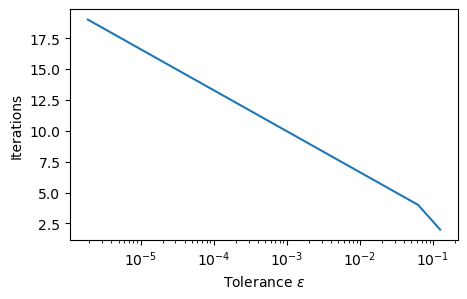

In [16]:
plot_iter_vs_tol(optimizer, func=f2)

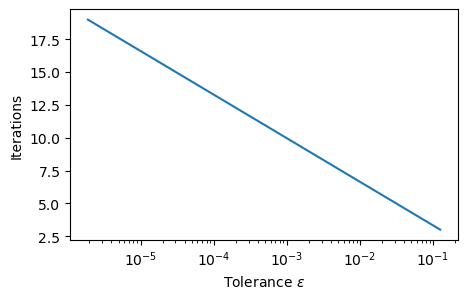

In [17]:
plot_iter_vs_tol(optimizer, func=f4)